Improving Language Understanding by Generative Pre-Training 논문 일부 구현<br/>
https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf

### Transformer와 비교해 변경이 필요한 부분

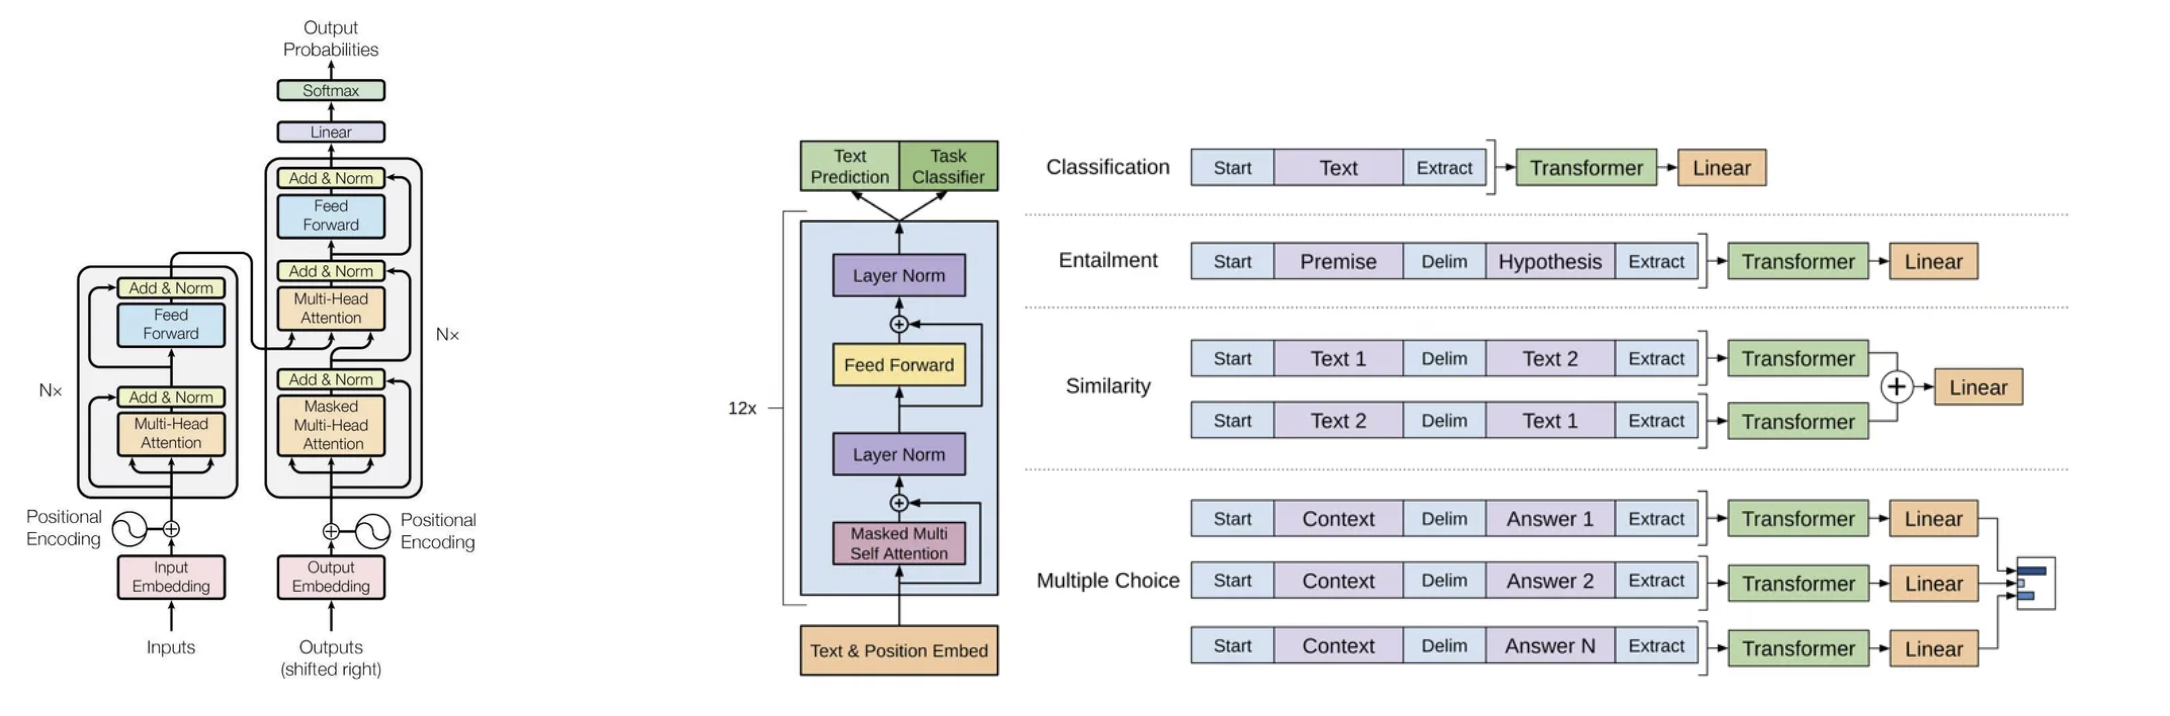

- GPT 모델은 인코더는 없고 디코더로만 이루어진 구조를 가지고 있음
- Transformer 모델과 달리 입력 구조를 재구성하는 입력 변환 과정이 필요함
- Transformer 모델은 입력에 포지셔널 인코딩을 더해주고, GPT 모델은 포지셔널 임베딩을 더함
- Transformer 모델은 디코더에서 Masked Self Attention과 Encoder-Decoder Attention을 사용한 반면 GPT 모델은 Masked Self Attention만 사용됨

## Pretrain을 위한 데이터셋과 학습만 고려한 GPT 모델

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

### 포지셔널 인코딩 레이어 삭제

### 임베딩 레이어

In [2]:
class EmbeddingLayer(tf.keras.layers.Layer):

  def __init__(self, vocab_size, max_position, d_model):
    super(EmbeddingLayer, self).__init__()
    ## 토큰 임베딩
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=d_model
    )
    ## 포지셔널 임베딩
    self.position_embedding = tf.keras.layers.Embedding(
        input_dim=max_position, 
        output_dim=d_model
    )
        
  def call(self, inputs):
    ## 토큰 임베딩
    token_embeddings = self.token_embedding(inputs)
        
    ## 포지셔널 임베딩
    seq_length = tf.shape(inputs)[1] # 시퀀스 길이
    positions = tf.range(start=0, limit=seq_length, delta=1) # 토큰 위치 데이터 형성
    positions = tf.expand_dims(positions, axis=0) # 배치 단위로 누적해서 차원 늘리기
        
    positional_embeddings = self.position_embedding(positions)
    
    # h0 = U*We + Wp
    h0 = token_embeddings + positional_embeddings
        
    return h0

### 어텐션

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.query_dense(key)
    value = self.query_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 마스킹

In [6]:
# 패딩 마스크
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스크
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더 레이어, 인코더 함수 삭제

### 디코더

In [7]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    
  # 패딩 마스크 삭제

  # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 인코더-디코더 어텐션 삭제

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [28]:
def decoder(max_length,
            vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
  inputs = tf.keras.Input(shape=(None,), name='inputs')

  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    
  # 패딩 마스크 삭제
  
  # 임베딩 레이어 변경
  ## 토큰 임베딩 레이어 + 포지셔널 임베딩 레이어
  embeddings = EmbeddingLayer(vocab_size, max_length, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩 삭제

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

### 데이터 불러오기

In [9]:
import pandas as pd

data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 11823


,Q,A,label
7984,전남친소식을들었어,신경이 쓰일 수도 있겠어요.,1
1408,또 살찐 거 같아,기분일꺼에요.,0
10773,예쁘면 다냐ㅠㅠ,마음 아프게 했나봐요.,2
3301,오늘 아무 것도 안 가져 왔다,개념만 가져오면 돼요.,0
1300,돈 어디갔지,퍼가요~,0
2720,시간표 잘못짰다,정정기간을 노려 보세요.,0
5178,화이트데이에 뭐 선물하지,사탕 만들어요.,0
11511,짝녀가 우리 과에서 제일 인기가 많은 듯.,사람들 보는 눈이 비슷하죠.,2
1983,방탈출 게임 했어,성공했길 바랍니다.,0
1557,맛집 다녀왔어,맛있게 드시고 오셨길 바랍니다.,0


In [10]:
print(len(data["Q"]))
print(len(data["A"]))

11823
11823


In [11]:
questions = []
for sentence in data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)
    
answers = []
for sentence in data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [12]:
#questions = data["Q"]
#answers = data["A"]
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [13]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### 데이터 전처리

In [14]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# 토큰화를 처리해준 후 토크나이저에 데이터를 넣으니 에러가 발생해서 따로 전처리해주는 과정은 생략
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# 구분 토큰 추가
DELIM_TOKEN = [tokenizer.vocab_size + 2]

In [16]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('DELIM_TOKEN의 번호 :' ,[tokenizer.vocab_size + 2])

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]
DELIM_TOKEN의 번호 : [8180]


In [17]:
# 시작 토큰과 종료 토큰, 구분 토큰을 고려하여 +3을 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8181


In [18]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[21]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 2495, 4167]
기존 문장: 가스비 장난 아님


In [19]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
2495 ----> 장난 
4167 ----> 아님


In [38]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 80
print(MAX_LENGTH)

80


In [39]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs = []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1)
    sentence2 = tokenizer.encode(sentence2) + END_TOKEN
    # 구분 토큰 추가
    sentence = sentence1 + DELIM_TOKEN + sentence2

    # 각 문장의 최대 길이가 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= (MAX_LENGTH/2) and len(sentence2) <= (MAX_LENGTH/2):
      tokenized_inputs.append(sentence)
  
  # 최대 길이 80으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [40]:
input_data = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(input_data)))

단어장의 크기 : 8181
필터링 후의 샘플 개수: 11823


In [41]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': input_data[:, :-1]
    },
    {
        'outputs': input_data[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 트랜스포머

In [42]:
def transformer(max_length,
                vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="GPT"):
    
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)
    
  # 디코더 패딩 마스크 제거

  # 인코더 제거

  # 디코더
  dec_outputs = decoder(
      max_length=max_length,
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

### 모델 정의 및 학습

In [43]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    max_length=MAX_LENGTH,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "GPT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    6861056     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8181)   2102517     decoder[0][0]                  

In [44]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

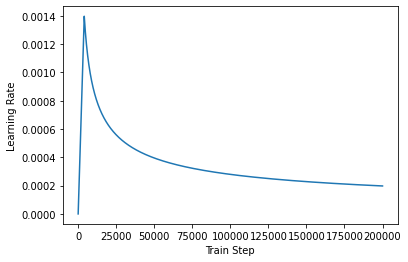

In [46]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [47]:
learning_rate = CustomSchedule(D_MODEL)

#optimizer = tf.keras.optimizers.Adam(
#    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 논문에서 옵티마이저 SGD 사용함
optimizer = tf.keras.optimizers.SGD(learning_rate)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 5
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/5
185/185 [==============================] - 56s 169ms/step - loss: 1.5194 - accuracy: 1.2848e-05
Epoch 2/5
185/185 [==============================] - 32s 174ms/step - loss: 1.5179 - accuracy: 1.2848e-05
Epoch 3/5
185/185 [==============================] - 33s 179ms/step - loss: 1.5148 - accuracy: 3.5331e-05
Epoch 4/5
185/185 [==============================] - 34s 183ms/step - loss: 1.5103 - accuracy: 3.5117e-04
Epoch 5/5
185/185 [==============================] - 35s 187ms/step - loss: 1.5043 - accuracy: 0.0033


### 테스트

In [48]:
def preprocess_test_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [52]:
def decoder_inference(sentence):
  sentence = preprocess_test_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=sentence, training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [53]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [54]:
sentence_generation('오늘 날씨 좋다')

입력 : 오늘 날씨 좋다
출력 :  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

In [55]:
sentence_generation("사과 먹을래?")

입력 : 사과 먹을래?
출력 :  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

In [56]:
sentence_generation("커피향이 좋다")

입력 : 커피향이 좋다
출력 :  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

In [57]:
sentence_generation("카페 갈래?")

입력 : 카페 갈래?
출력 :  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

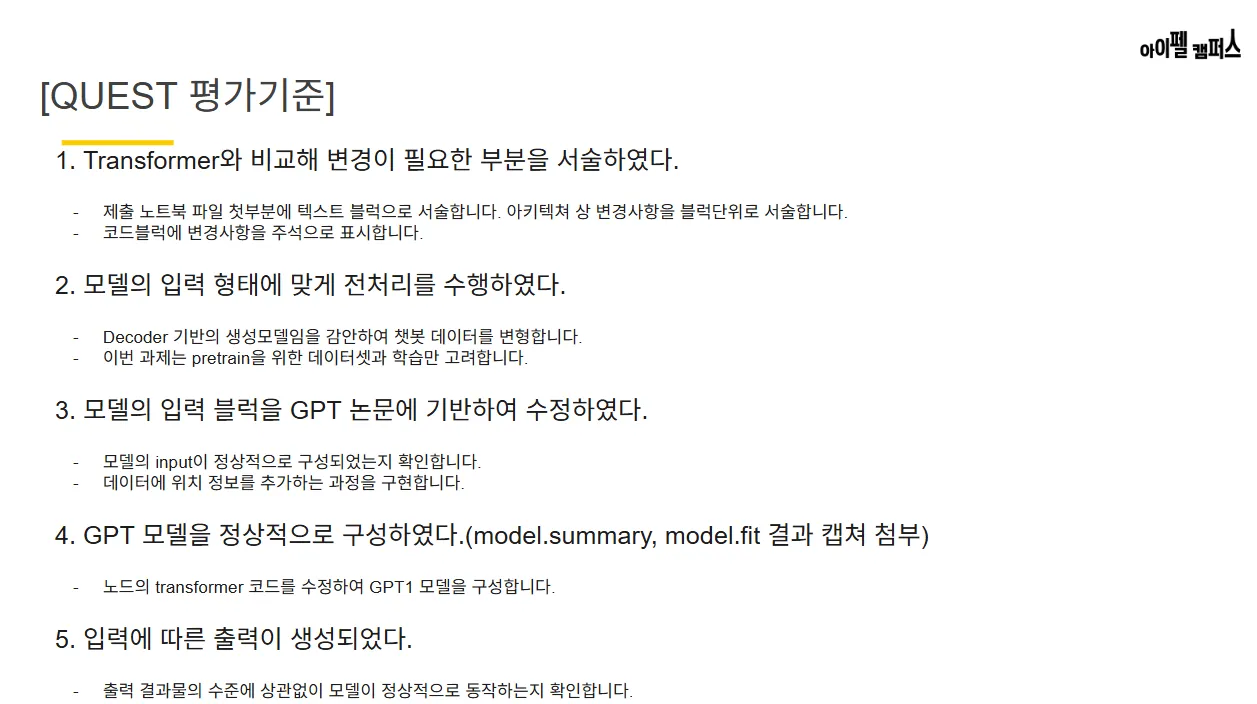

> - model.summary 결과 캡쳐
> ---
> 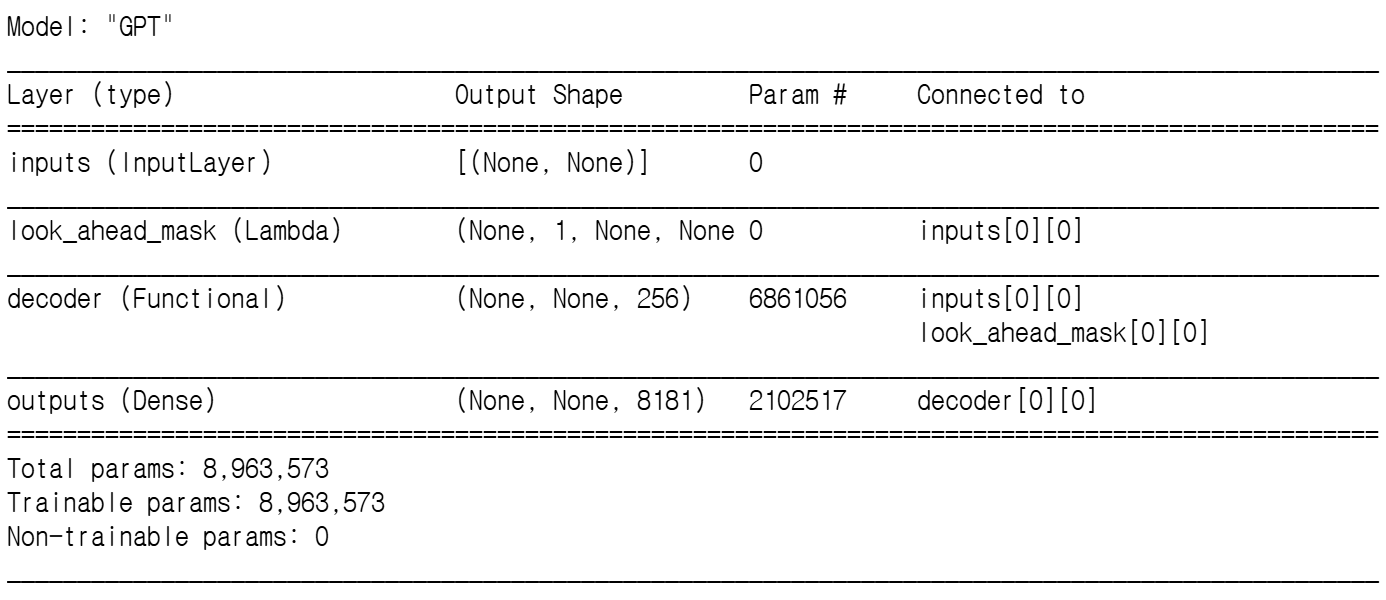

> - model.fit 결과 캡쳐
> ---
> 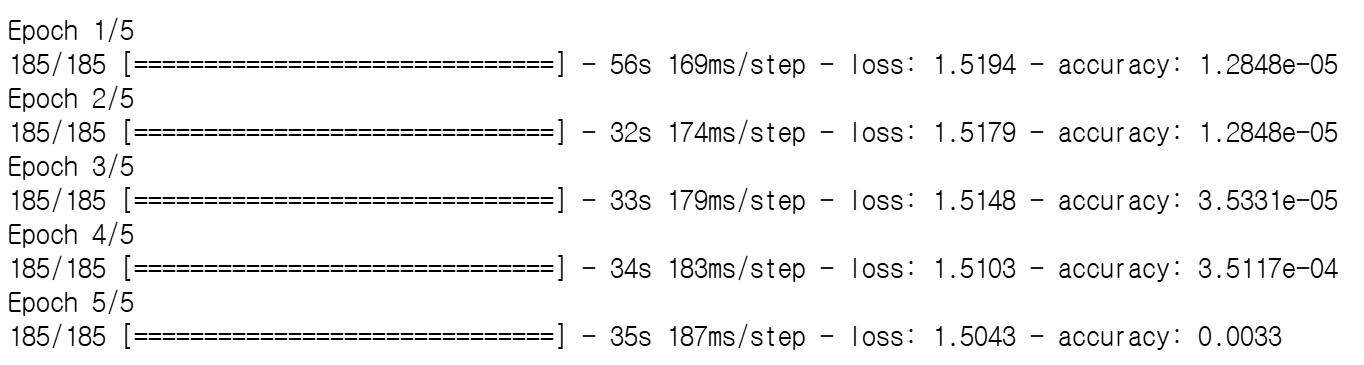